# 🎈분석 결과를 토대로 자율주행에 적합한 데이터 선별
- 학습 시간을 고려하여 데이터를 최대 1만 장, 이미지 사이즈(960,512)를 사용하기로 함. (데이터 1000장, 이미지 사이즈:(1920,1024), epoch:100, GPU:v100, 학습 시간: 6시간)

## 1. 객체 분포를 기준으로 1만 장 선별
   - 분류학습을 위해서는 객체의 수가 많을수록 좋다고 생각하였고 그래서 적은 객체를 모두 포함할 수 있는 방향으로 데이터를 우선 선별하여 객체가 최대한 고르게 분포하도록 하였음.
   
## 2. 전, 후, 측 방 데이터를 기준으로 1만 장 선별
   - 학습 시간을 알아보기 위한 yolov7 학습 결과에서 분류 학습 시에 전방 이미지가 많이 들어가서 차량의 후방이미지에 대한 분류는 잘 이루어졌지만, 전방 이미지를 잘 분류하지 못하는 것을 확인하였고 그를 토대로 객체의 모든 부분을 골고루 학습시키기 위해 후, 측방을 다 포함하고 나머지를 전방 이미지로 하여 1만 장을 선별함.
   - 또한 우리가 분류할 객체를 팀 간 협의하여 4개로 수정 (car, truck, bus, pedestrian(adult, child, specialclothes))

In [1]:
import matplotlib.pyplot as plt
import cv2
from glob import glob
import json
import os
img_path = sorted(glob('/aiffel/aiffel/aiffelthon/random_1000/*.png'))
json_path = sorted(glob('/aiffel/aiffel/aiffelthon/random_1000/*.json'))

#  새로운 json을 저장할 폴더 생성
# !mkdir -p /aiffel/aiffel/aiffelthon/new_json
# 이미지, 라벨 순서 다른게 있는지 확인
for i, j in zip(img_path, json_path):
    if i.split('/')[-1][:-4]!=j.split('/')[-1][:-13]:
        print(i.split('/')[-1][:-4] , j.split('/')[-1][:-13])

    
# 데이터 만들기
new_json = {}
for i, j in zip(img_path, json_path):
    with open(j, 'r')as f:# json 읽어오기
        json_ = json.load(f)
        
    # 새로운 json에 meta정보 추가
    new_json = {'filename': json_['filename'], 'weather': json_['weather'], 'illumination_status': json_['illumination_status'],\
                'road_status': json_['road_status'],'crowd_level': json_['crowd_level'], 'sensor_status': json_['sensor_status']}
    
    # 새로운 json에 annotation정보 추가
    anno = []
    for k in json_['annotations']:
        # 가짜 이미지가 아니고
        if k['isfake'] == 0:    
            # 클래스가 내가 원하는 클래스이면 새로운 json에 추가
            bbox = k['points']
            # bbox 정규화
            norm_bbox = [[bbox[0][0]/1920, bbox[0][1]/1024],[bbox[1][0]/1920, bbox[1][1]/1024],\
                         [bbox[2][0]/1920, bbox[2][1]/1024],[bbox[3][0]/1920, bbox[3][1]/1024]]
            if k['attribute'] == 'car':
                anno.append({'id': k['id'], 'type': k['type'], 'attribute': 'car', 'points': norm_bbox,\
                         'occlusion': k['occlusion'], 'truncation':  k['truncation'], 'scenario':  k['scenario'],\
                            'isfake': k['isfake'],'ismask': k['ismask'], 'area':  k['area']})

            elif k['attribute'] in ['adult','specialclothes','child']:
                anno.append({'id': k['id'], 'type': k['type'], 'attribute': 'pedestrian', 'points': norm_bbox,\
                         'occlusion': k['occlusion'], 'truncation':  k['truncation'], 'scenario':  k['scenario'],\
                             'isfake': k['isfake'],'ismask': k['ismask'], 'area':  k['area']})

            elif k['attribute'] in ['truck_s','truck_l']:
                anno.append({'id': k['id'], 'type': k['type'], 'attribute': 'truck', 'points': norm_bbox,\
                         'occlusion': k['occlusion'], 'truncation':  k['truncation'], 'scenario': k['scenario'],\
                             'isfake': k['isfake'],'ismask': k['ismask'], 'area':  k['area']})

            elif k['attribute'] in ['bus_l','bus_s']:
                anno.append({'id': k['id'], 'type': k['type'], 'attribute':  'bus', 'points': norm_bbox,\
                         'occlusion': k['occlusion'], 'truncation':  k['truncation'], 'scenario':  k['scenario'],\
                             'isfake': k['isfake'],'ismask': k['ismask'], 'area':  k['area']})
                
    #  이미지에 원하는 객체가 아무것도 없을때 확인용
#     if anno == []:
#         print("이미지에 원하는 객체가 없습니다.")
#         print(*[(f['attribute'],f['isfake']) for f in json_['annotations']], '\n')
#         plt.imshow(cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB))
#         plt.show()
        
    # 새로운 json 완성    
    new_json['annotations'] = anno
    
    new_json_path = '/aiffel/aiffel/aiffelthon/new_json/'
    # 전처리 후 이미지에 객체가 하나라도 있으면 new_json 저장
    if new_json['annotations'] !=[]:
#         print( new_json_path+new_json['filename'][:-4]+'.json')
        with open(new_json_path+new_json['filename'][:-4]+'.json', 'w')as f:
            json.dump(new_json,f)

## 최종 선별한 데이터 EDA

In [2]:
#csv 파일 생성
import pandas as pd
jsons = sorted(glob('/aiffel/aiffel/datasets/final_dataset/labels/*.json'))

meta = pd.DataFrame()
anno = pd.DataFrame()
for i in jsons:

    with open(i, 'r') as f:
        data = json.load(f)


    annot = data['annotations']
    
    for i in range(len(annot)):
        annot[i]['filename'] = data['filename']
    data.pop('annotations')
    annot = pd.DataFrame(annot)
    meta = meta.append([data], ignore_index=True)
    anno = pd.concat([anno, annot])

meta.to_csv('final_meta.csv', encoding = 'utf-8',index = False)
anno.to_csv('final_anno.csv', encoding = 'utf-8',index = False)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

meta = pd.read_csv('final_meta.csv')
meta.head()

,filename,weather,illumination_status,road_status,crowd_level,sensor_status
0,1654739004396_FR-View-CMR-Wide.png,cloudy,normal,dry,high,reflection_from_dashboard
1,1654739005761_FR-View-CMR-Wide.png,cloudy,normal,dry,high,reflection_from_dashboard
2,1654739007265_FR-View-CMR-Wide.png,cloudy,normal,dry,high,reflection_from_dashboard
3,1654739009784_FR-View-CMR-Wide.png,cloudy,normal,dry,high,reflection_from_dashboard
4,1654739012828_FR-View-CMR-Wide.png,cloudy,normal,dry,high,reflection_from_dashboard


In [4]:
anno =  pd.read_csv('final_anno.csv')
anno.head()

,id,type,attribute,points,occlusion,truncation,scenario,isfake,ismask,area,filename
0,1-8eedd817-09f5-4e27-9539-52de79d01477,bbox,car,"[[0.9375, 0.583984375], [1.0, 0.583984375], [1...",1,1,0,0,0,10680,1654739004396_FR-View-CMR-Wide.png
1,2-da020894-3da7-4bf9-8916-d25b942602dc,bbox,truck,"[[0.8572916666666667, 0.5771484375], [0.953645...",2,0,0,0,0,9065,1654739004396_FR-View-CMR-Wide.png
2,6-42a33f5a-4c64-4d5f-a8dc-4e922f69e197,bbox,truck,"[[0.5213541666666667, 0.52734375], [0.61927083...",1,0,0,0,0,25756,1654739004396_FR-View-CMR-Wide.png
3,7-49b34850-940f-4cc0-9c7b-7a09d01c9500,bbox,truck,"[[0.7869791666666667, 0.580078125], [0.84375, ...",0,0,0,0,0,8502,1654739004396_FR-View-CMR-Wide.png
4,8-93a17028-dbf2-4fec-877f-8dd690f7ea5f,bbox,car,"[[0.16041666666666668, 0.5537109375], [0.46197...",0,0,0,0,0,207282,1654739004396_FR-View-CMR-Wide.png


## 📈meta 데이터 시각화

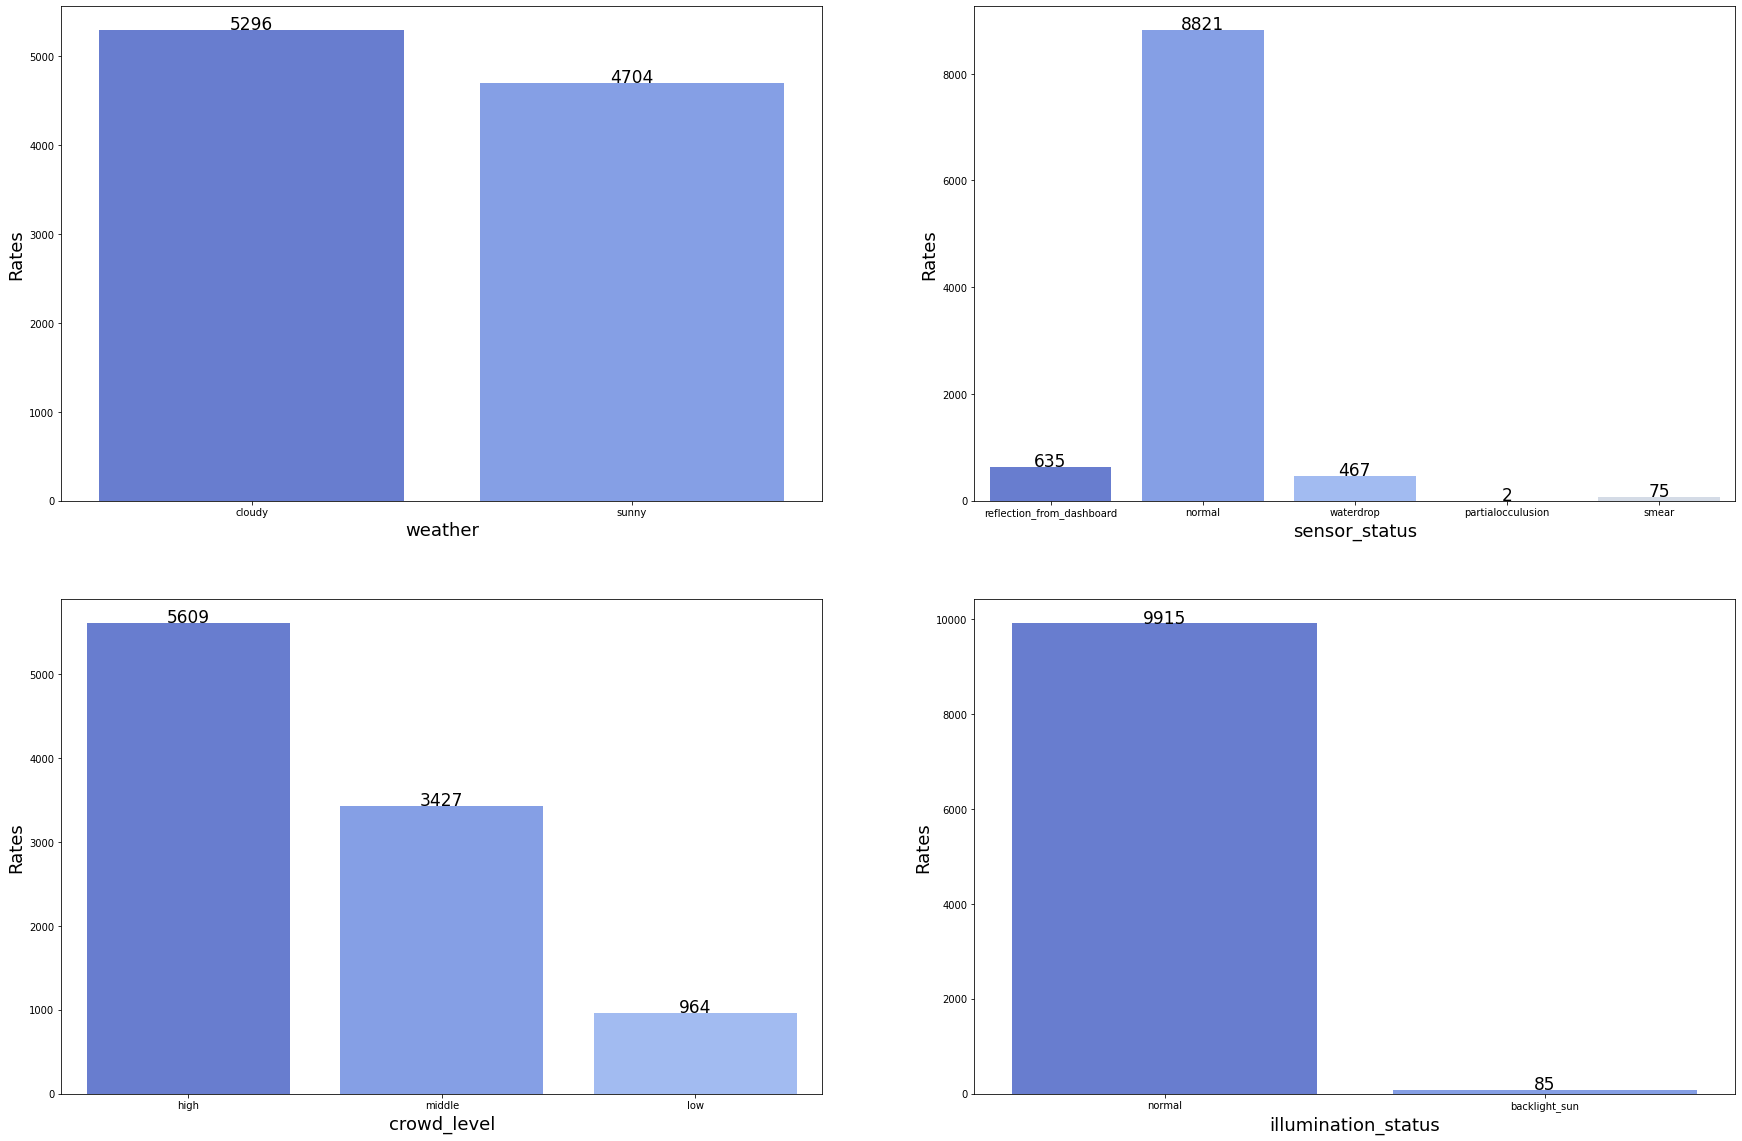

In [6]:
palette = sns.color_palette('coolwarm', 10)
plot_list = ['weather','sensor_status','crowd_level','illumination_status']
plt.figure(figsize=(30, 20))
# plt.subplots(constrained_layout=True)
for i in range(len(plot_list)):
    plt.subplot(2,2,i+1)
    ax = sns.countplot(x = plot_list[i], data = meta, palette = palette)
    plt.xlabel(plot_list[i],fontsize = 18)
    plt.ylabel('Rates',fontsize = 18)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height+5, height, ha = 'center', size = 17)

## 📉annotations 시각화

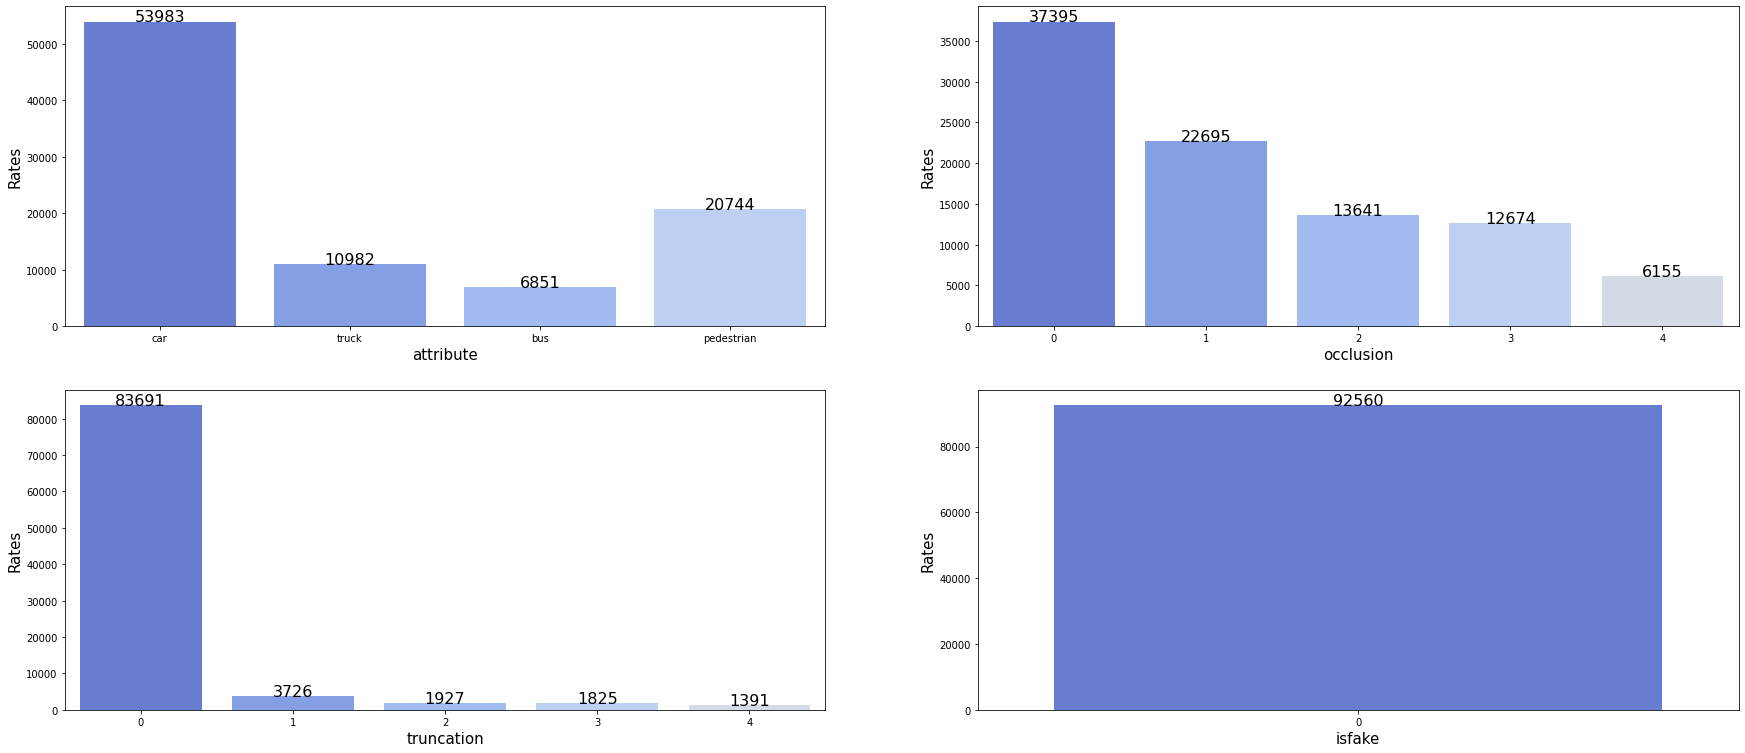

In [7]:
plot_list = ['attribute','occlusion','truncation','isfake']
plt.figure(figsize=(30, 20))
# plt.subplots(constrained_layout=True)
for i in range(len(plot_list)):
    plt.subplot(3,2,i+1)
    ax = sns.countplot(x = plot_list[i], data = anno, palette = palette)
    plt.xlabel(plot_list[i],fontsize = 15)
    plt.ylabel('Rates',fontsize = 15)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height+5, height, ha = 'center', size = 16)

## 🎈전방이미지와 후,측방 이미지 수

In [8]:
rr = [i for i in meta['filename'] if i[14:16]!='FR']# 후,측방 이미지 수      
fr = [i for i in meta['filename'] if i[14:16]=='FR'] # 전방 이미지 수
len(fr), len(rr)

(5546, 4454)

## 📝최종 선별한 데이터 분석 결과
- 우리가 원했던 후, 측방 이미지를 최대한 포함한 결과 후, 측방 이미지 4454장을 수집할 수 있었다.
- 라벨링도 4가지(car, truck, bus, pedestrian) 클래스에 대해 잘 분리된 것을 확인할 수 있다. 
- isfake에 대해서도 가짜 이미지를 모두 빼는 게 좋겠다는 피드백을 수용하여 모두 제거하였다.